In [83]:
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import numpy as np
import rupho as rp
import pylab as pl
%matplotlib qt

In [84]:
def generate_terrain_volume(size=100, scale=1.0, smooth=3):
    """
    Generate a 3D binary volume (n x n x n) based on a 2D terrain.
    Voxels below the terrain surface are filled (value=1), others are empty (value=0).
    """
    # Generate smoothed 2D terrain
    x = np.linspace(0, 1, size)
    y = np.linspace(0, 1, size)
    X, Y = np.meshgrid(x, y)
    noise = np.random.rand(size, size)
    terrain = gaussian_filter(noise, sigma=smooth) * scale

    # Normalize terrain to voxel grid height range
    terrain_normalized = (terrain - terrain.min()) / (terrain.max() - terrain.min())
    terrain_voxels = (terrain_normalized * (size - 1)).astype(int)

    # Create 3D binary volume
    volume = np.zeros((size, size, size), dtype=np.uint8)
    for i in range(size):
        for j in range(size):
            h = terrain_voxels[i, j]
            volume[i, j, :h+1] = 1  # fill below terrain

    return volume, X, Y, terrain


In [85]:
def fractal_dimension(volume):
    # finding all the non-zero pixels
    voxels = []
    Lx, Ly, Lz = volume.shape
    
    for i in range(Lx):
        for j in range(Ly):
            for k in range(Lz):
                if volume[i, j, k]>0:
                    voxels.append((i, j, k))
    
   
    print("Dimensions:", Lx, Ly, Lz)
    voxels = np.array(voxels)
    print("Number of non-zero voxels:", voxels.shape[0])
    
    # computing the fractal dimension
    # considering only scales in a logarithmic list
    scales = np.logspace(0.01, 1, num=10, endpoint=False, base=2)
    Ns=[]
    # looping over several scales
    for scale in scales:
        print (scale)
        # computing the histogram
        H, edges = np.histogramdd(voxels, bins=(np.arange(0, Lx, scale), np.arange(0, Ly, scale), np.arange(0, Lz, scale)))
        Ns.append(np.sum(H>0))
    
    # linear fit, polynomial of degree 1
    coeffs = np.polyfit(np.log(scales), np.log(Ns), 1)
    return -coeffs[0], coeffs, scales, Ns

In [86]:
volume, X, Y, Z = generate_terrain_volume(size=100, scale=3, smooth=10)

D, coeffs, scales, Ns = fractal_dimension(volume)
print("The Hausdorff dimension is ",D)
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X, Y, Z, cmap='terrain', linewidth=0, antialiased=False)
ax1.set_title("Random Terrain")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.set_zlabel("Z")
ax1.set_zlim(1,2)

ax2 = fig.add_subplot(122)
ax2.plot(np.log(scales), np.polyval(coeffs, np.log(scales)))
ax2.plot(np.log(scales),np.log(Ns), 'o', color="red", markerfacecolor="none")
ax2.set_title("Linear regression")
ax2.set_xlabel(r'log $\epsilon$')
ax2.set_ylabel(r'log N')
ax2.grid()

plt.tight_layout()
plt.show()


Dimensions: 100 100 100
Number of non-zero voxels: 368893
1.0069555500567189
1.0784804316944516
1.1550857845535842
1.2371324786871727
1.3250070170452075
1.4191233562003824
1.5199248564015158
1.6278863701408692
1.7435164790741244
1.8673598898306263
The Hausdorff dimension is  2.946163011316586


In [87]:
def generate_multifractal_field(size, alpha=1.8, C1=0.1, H=0.5):
    """
    Generate a 2D multifractal field using the Universal Multifractal model.

    Parameters:
    - size: Tuple (nx, ny) specifying the dimensions of the field.
    - alpha: Multifractality index (0 < alpha <= 2).
    - C1: Codimension parameter (0 < C1 < alpha).
    - H: Hurst exponent (0 < H < 1).

    Returns:
    - A 2D numpy array representing the multifractal field.
    """
    nx, ny = size
    kx = np.fft.fftfreq(nx).reshape(-1, 1)
    ky = np.fft.fftfreq(ny).reshape(1, -1)
    k = np.sqrt(kx**2 + ky**2)
    k[0, 0] = 1e-10  # Avoid division by zero at the origin

    # Generate random phases
    phi = np.random.uniform(0, 2 * np.pi, (nx, ny))
    noise = np.exp(1j * phi)

    # Apply the spectral amplitude
    amplitude = k ** (-(H + 1))
    spectrum = noise * amplitude

    # Inverse Fourier transform to get the spatial field
    field = np.fft.ifft2(spectrum).real

    # Normalize the field
    field -= field.min()
    field /= field.max()

    # Apply the universal multifractal transformation
    field = np.exp(-C1 * field ** alpha)

    return field

# Parameters
size = (512, 512)
alpha = 1.8  # Multifractality index
C1 = 0.1     # Codimension parameter
H = 0.5      # Hurst exponent

# Create a meshgrid for plotting
x = np.linspace(0, 1, size[0])
y = np.linspace(0, 1, size[1])
X, Y = np.meshgrid(x, y)

# Generate the multifractal field
terrain = generate_multifractal_field(size, alpha, C1, H)


In [88]:
def generate_multifractal_field(size, alpha=1.8, C1=0.1, H=0.5):
    nx, ny = size
    kx = np.fft.fftfreq(nx).reshape(-1, 1)
    ky = np.fft.fftfreq(ny).reshape(1, -1)
    k = np.sqrt(kx**2 + ky**2)
    k[0, 0] = 1e-10

    phi = np.random.uniform(0, 2 * np.pi, (nx, ny))
    noise = np.exp(1j * phi)
    amplitude = k ** (-(H + 1))
    spectrum = noise * amplitude
    field = np.fft.ifft2(spectrum).real
    field -= field.min()
    field /= field.max()
    field = np.exp(-C1 * field ** alpha)

    return field

def compute_shading(elevation, light_vector):
    dx, dy = np.gradient(elevation)
    normal = np.dstack((-dx, -dy, np.ones_like(elevation)))
    norm = np.linalg.norm(normal, axis=2)
    normal /= norm[..., np.newaxis]

    light_vector = np.array(light_vector)
    light_vector = light_vector / np.linalg.norm(light_vector)

    shading = np.clip(np.tensordot(normal, light_vector, axes=([2], [0])), 0, 1)
    return shading

# Parameters
size = (512, 512)
alpha = 1.8
C1 = 0.1
H = 0.5
light_vector = [1, 1, 1]  # Incident light direction

# Generate terrain
terrain = generate_multifractal_field(size, alpha, C1, H)
shading = compute_shading(terrain, light_vector)

# Visualization
fig, ax = plt.subplots()
ax.imshow(shading, cmap='gray', origin='lower')
ax.set_title('Shaded Relief of Multifractal Terrain')
ax.axis('off')
plt.tight_layout()
plt.show()


/home/tenet/miniconda3/lib/python3.12/site-packages/pyvista/jupyter/notebook.py:36: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


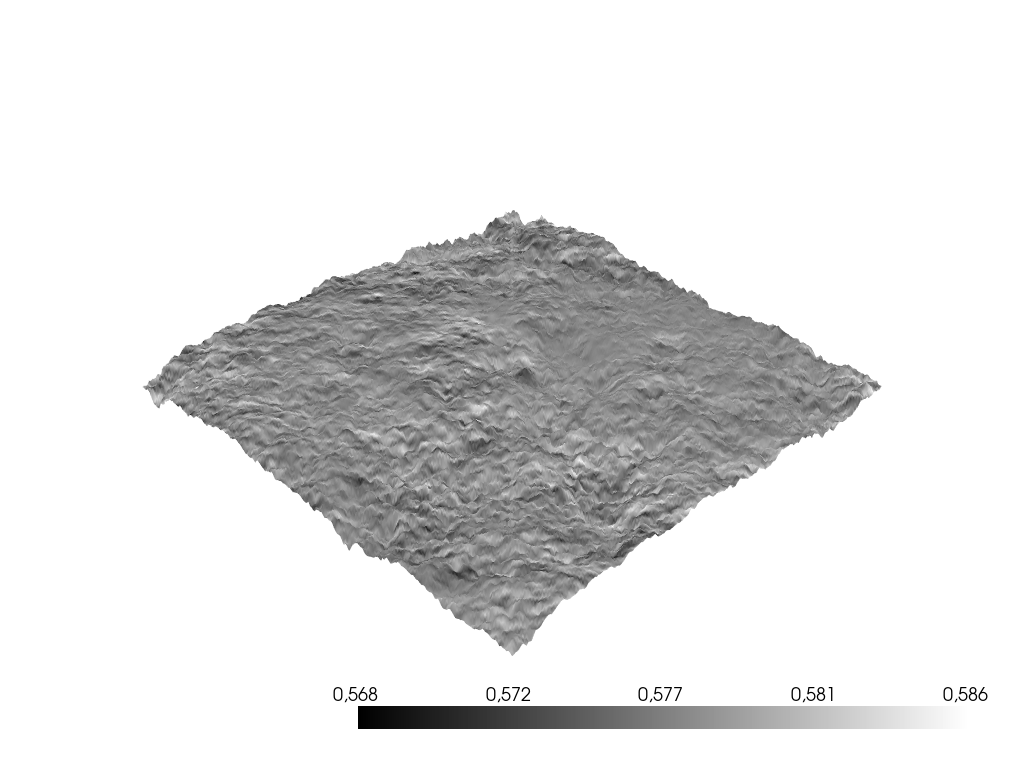

In [89]:
import pyvista as pv

def generate_multifractal_field(size, alpha=1.8, C1=0.1, H=0.5):
    nx, ny = size
    kx = np.fft.fftfreq(nx).reshape(-1, 1)
    ky = np.fft.fftfreq(ny).reshape(1, -1)
    k = np.sqrt(kx**2 + ky**2)
    k[0, 0] = 1e-10

    phi = np.random.uniform(0, 2 * np.pi, (nx, ny))
    noise = np.exp(1j * phi)
    amplitude = k ** (-(H + 1))
    spectrum = noise * amplitude
    field = np.fft.ifft2(spectrum).real
    field -= field.min()
    field /= field.max()
    field = np.exp(-C1 * field ** alpha)

    return field

# Parameters
size = (256, 256)
alpha = 1.8
C1 = 0.1
H = 0.5

terrain = generate_multifractal_field(size, alpha, C1, H)
shading = compute_shading(terrain, light_vector)

# Create grid
nx, ny = size
x = np.linspace(0, 1, nx)
y = np.linspace(0, 1, ny)
x, y = np.meshgrid(x, y)
z = terrain

# Create structured grid
grid = pv.StructuredGrid(x, y, z)
plotter = pv.Plotter()
plotter.add_mesh(grid, scalars=shading, cmap='gray', lighting=False)
plotter.show()